### Import the libraries needed

In [2]:
import networkx as nx
import numpy as np
import imageio.v2 as imageio
import os, random, string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
my_graph = nx.read_edgelist("../data/dataset.txt", create_using=nx.Graph(), nodetype=int)

In [4]:
graph_nodes_list = list(my_graph.nodes())
new_graph_size = 2000
new_graph_nodes = random.sample(graph_nodes_list, new_graph_size)
new_graph = my_graph.subgraph(new_graph_nodes)
print("New Graph - Number of nodes: ", new_graph.number_of_nodes())
print("New Graph - Number of edges: ", new_graph.number_of_edges())

giant_component = max(nx.connected_components(new_graph), key=len)
giant_component_graph = new_graph.subgraph(giant_component)

print("Giant Component - Number of nodes: ", giant_component_graph.number_of_nodes())
print("Giant Component - Number of edges: ", giant_component_graph.number_of_edges())

New Graph - Number of nodes:  2000
New Graph - Number of edges:  818
Giant Component - Number of nodes:  373
Giant Component - Number of edges:  489


### Prepare the network

In [5]:
# Step 1: Prepare the Network
G = giant_component_graph
pos = nx.spring_layout(G, seed=42)

### Node Types

In [6]:
node_colors = {node: 'blue' for node in G.nodes()} # All start as blue
gossipers = np.random.choice(G.nodes(), 20, replace=False)  
malicious = np.random.choice(list(set(G.nodes()) - set(gossipers)), 20, replace=False) 

# Messages
original_message = "super secret sentence"
information = {node: None for node in G.nodes()}

for node in gossipers:
    information[node] = original_message

### Simulation Parameters

In [7]:
# Simulation Parameters
threshold = 0.2

# Mark Gossipers as Green
for node in gossipers: node_colors[node] = 'green'

# Mark malicious nodes as red initially
for node in malicious: node_colors[node] = 'red'  # Mark malicious as red initially

# Simulation Step


In [8]:
def gossip_step():
    changes = False
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        num_informed = sum(1 for neighbor in neighbors if information[neighbor] is not None)

        if num_informed / len(neighbors) >= threshold and information[node] is None:
            # Choose a random informed neighbor to get the information from
            informed_neighbors = [n for n in neighbors if information[n] is not None]
            if informed_neighbors:
                selected_neighbor = np.random.choice(informed_neighbors)
                if node in malicious:
                    # Randomly select a character from the message and change it to another random character
                    index_to_replace = random.randint(0, len(information[selected_neighbor]) - 1)
                    new_char = random.choice(string.ascii_letters)
                    while new_char == information[selected_neighbor][index_to_replace]:
                        new_char = random.choice(string.ascii_letters)
                    information[node] = information[selected_neighbor][:index_to_replace] + new_char + information[selected_neighbor][index_to_replace + 1:]
                else:
                    information[node] = information[selected_neighbor]

            node_colors[node] = 'green'

            changes = True
    return changes

### Visualization and Main Loop


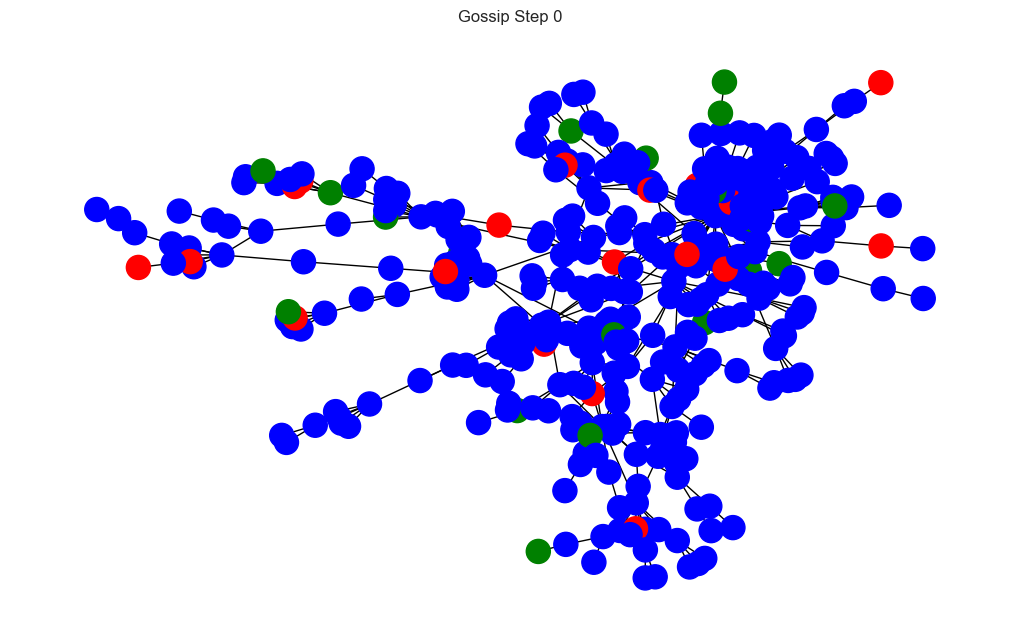

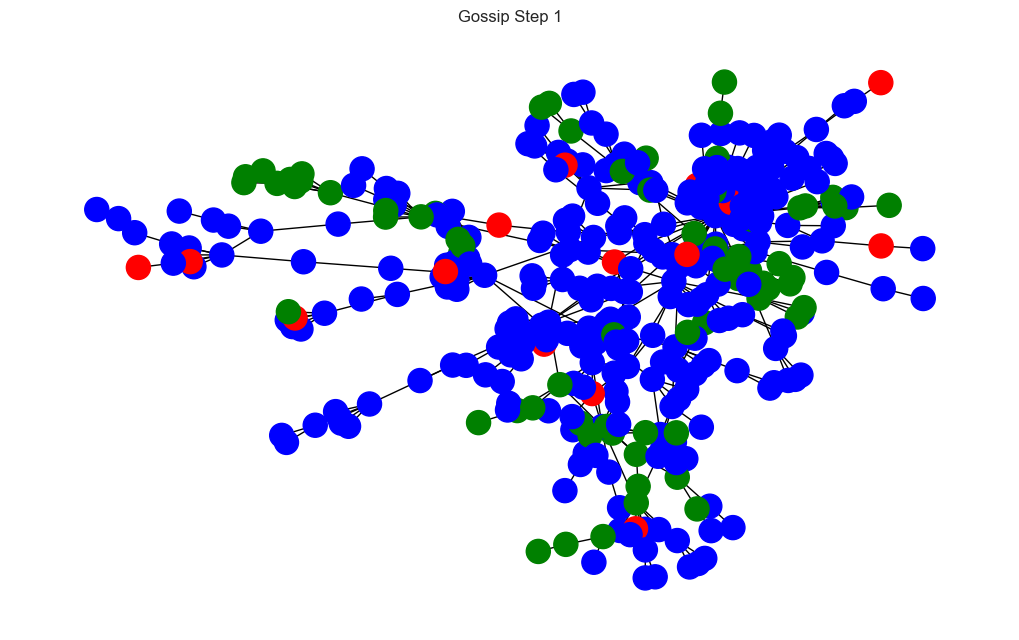

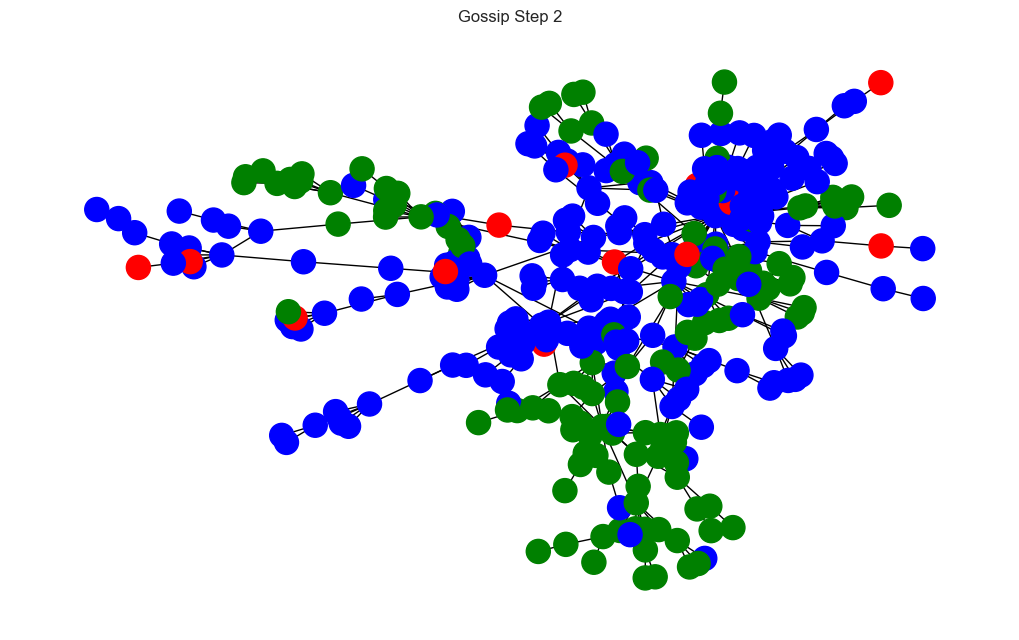

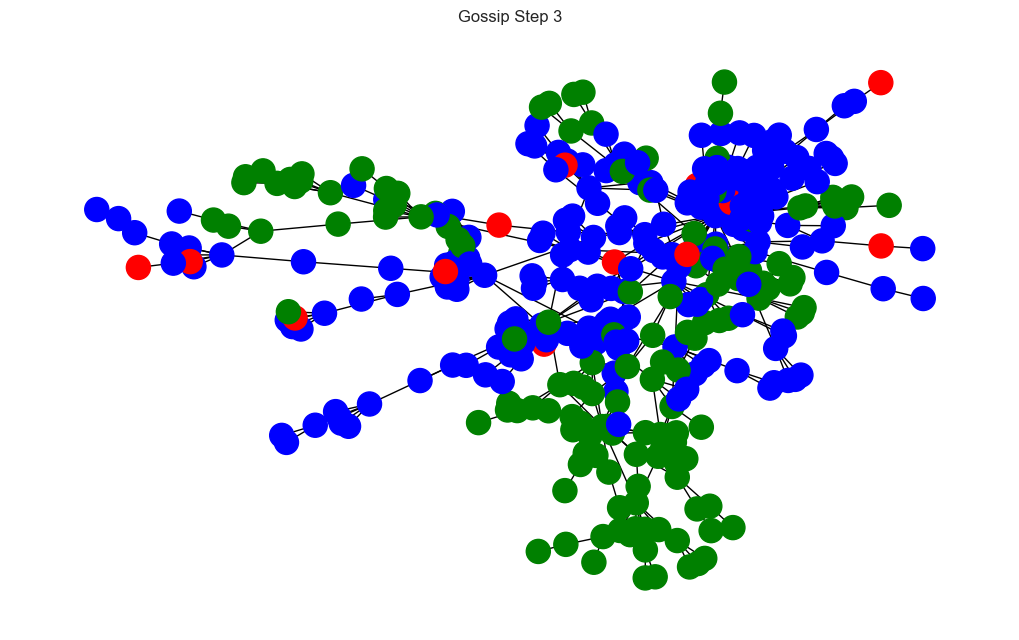

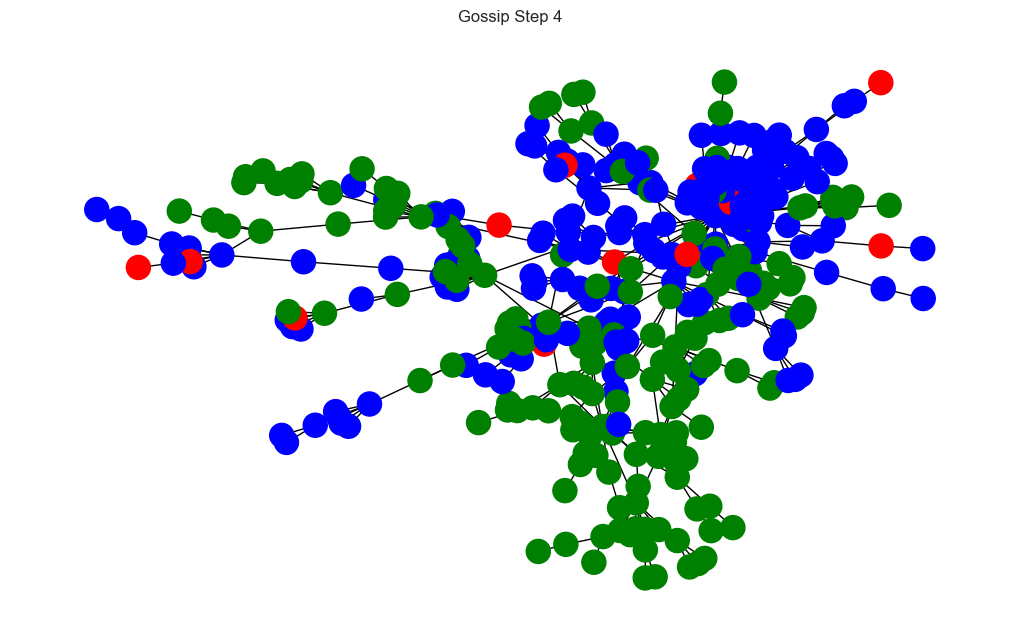

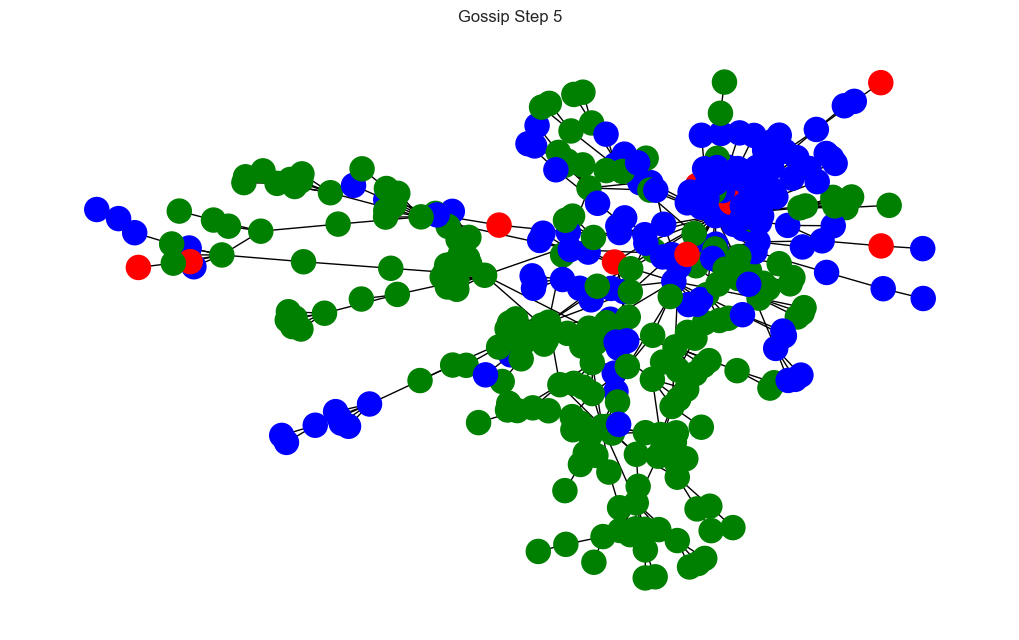

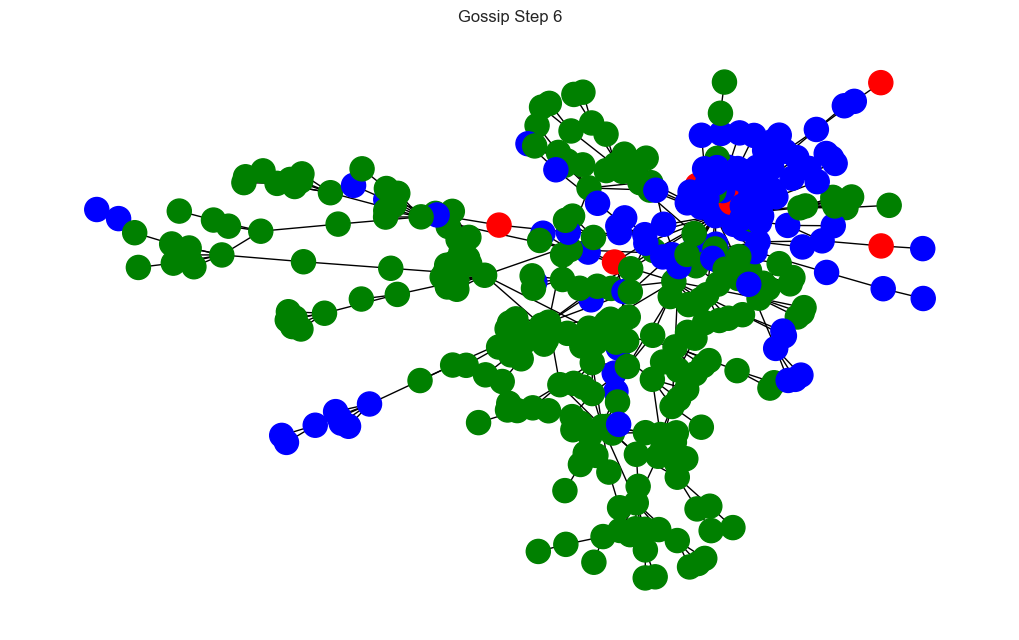

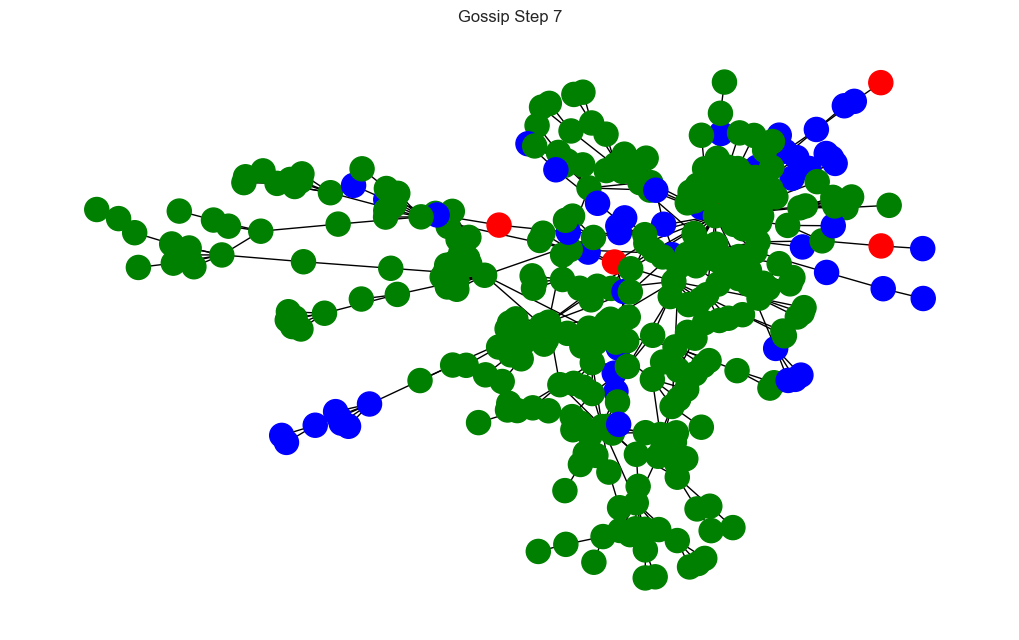

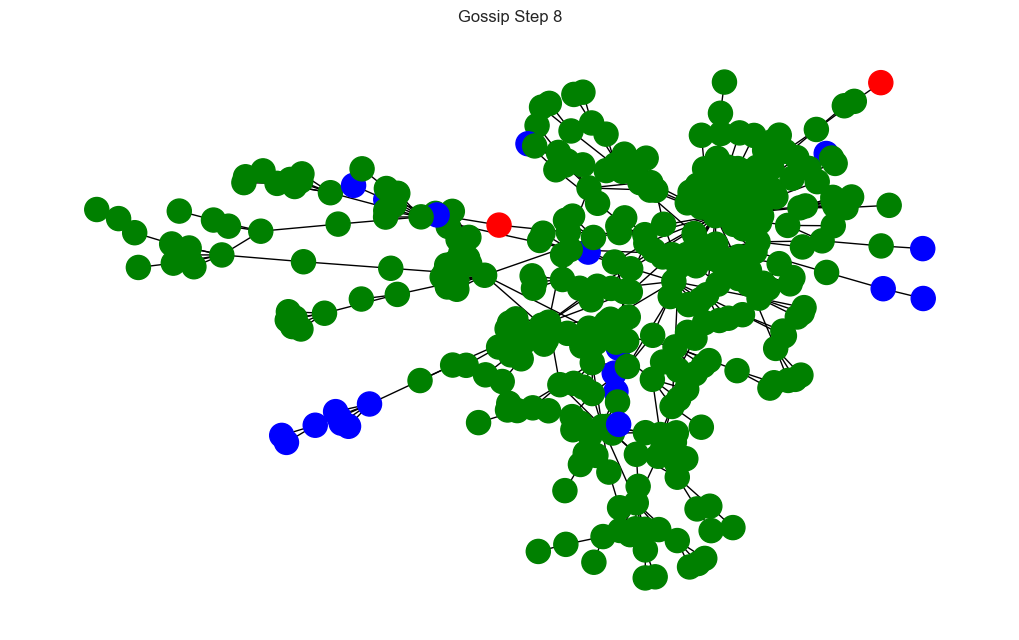

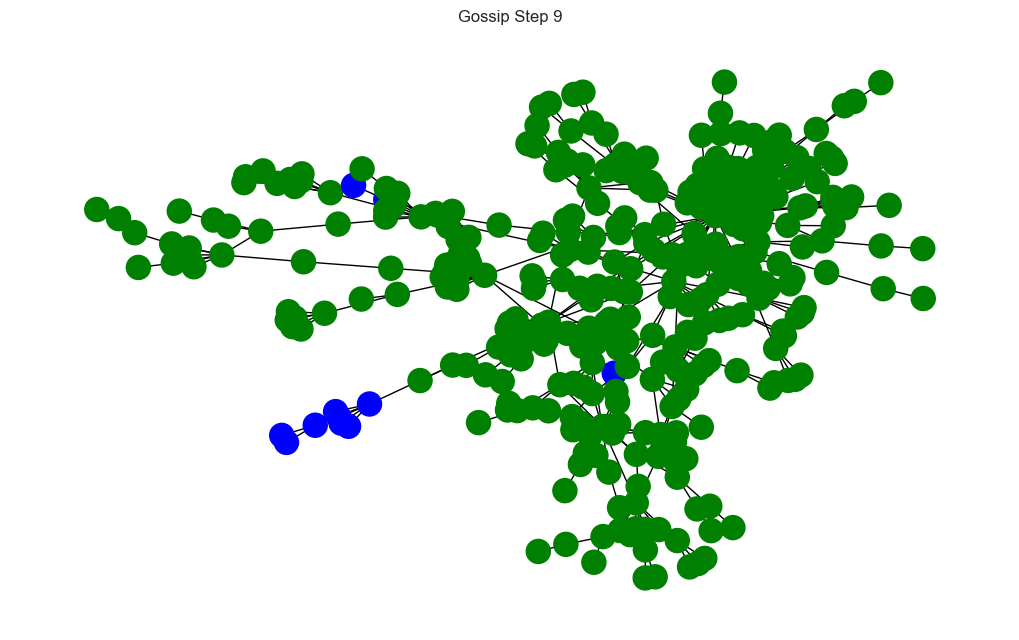

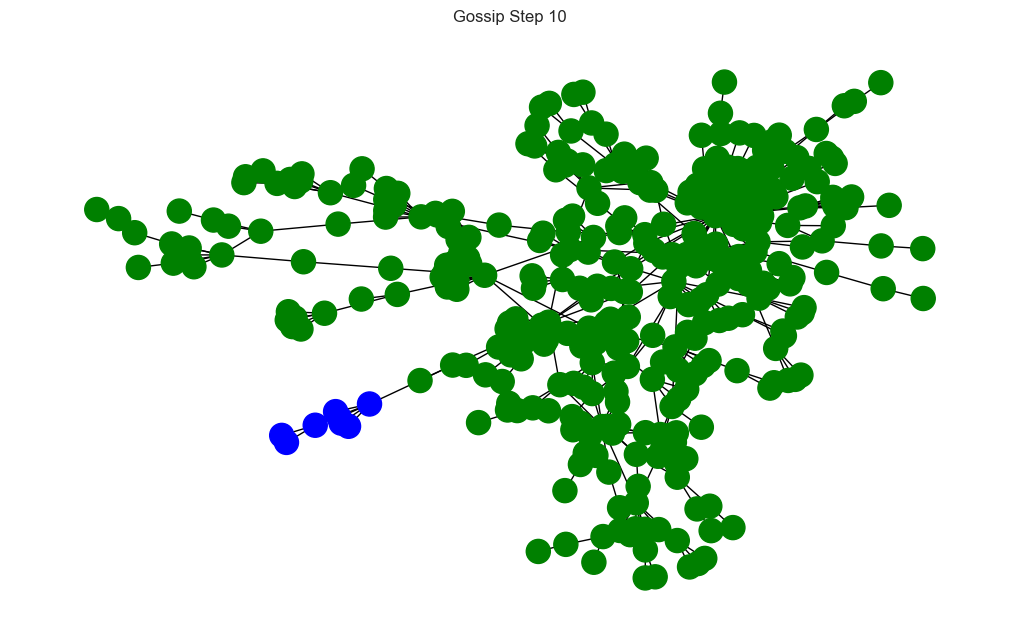

In [9]:
# Define the directory where you want to save the frames
output_dir = "frames"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Visualization and Main Loop
filenames = []
max_iterations = 15
iteration = 0

while iteration < max_iterations:

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, node_color=[node_colors[node] for node in G.nodes()])
    plt.title(f"Gossip Step {iteration}")

    
    filename = os.path.join(output_dir, f"frame_{len(filenames)}.png")
    filenames.append(filename)
    plt.savefig(filename)
    
    plt.show()
    plt.close()
    
    if not gossip_step(): break
    iteration += 1

### Video Creation

In [10]:
with imageio.get_writer('gossip_simulation.gif', mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [11]:
# Analyze Results
unique_info = set(information.values())
print("Unique information types received:", unique_info)

# Count occurrences of each information type
info_counts = {info: list(information.values()).count(info) for info in unique_info}
print("Count of each information type:", info_counts)

Unique information types received: {'super secret senqence', 'super secrzt sentence', 'super secret sentenIe', 'supjr secret sentence', 'sQper secret sentence', 'super secret sentedce', 'super secrem sentence', 'vuper secret sentence', None, 'super secret Ientence', 'sTper secret sentence', 'suBer secret sentence', 'surer secret sentence', 'super secret sentence', 'super secret senteHce', 'supNr secret sentence', 'super secrzt seUtence', 'super secretxsentence', 'puper secret sentence', 'superdsecret sentence', 'super secret sentenae'}
Count of each information type: {'super secret senqence': 1, 'super secrzt sentence': 1, 'super secret sentenIe': 2, 'supjr secret sentence': 4, 'sQper secret sentence': 1, 'super secret sentedce': 1, 'super secrem sentence': 1, 'vuper secret sentence': 1, None: 8, 'super secret Ientence': 1, 'sTper secret sentence': 4, 'suBer secret sentence': 2, 'surer secret sentence': 2, 'super secret sentence': 329, 'super secret senteHce': 1, 'supNr secret sentence

### Visualization of the Spread of Messages

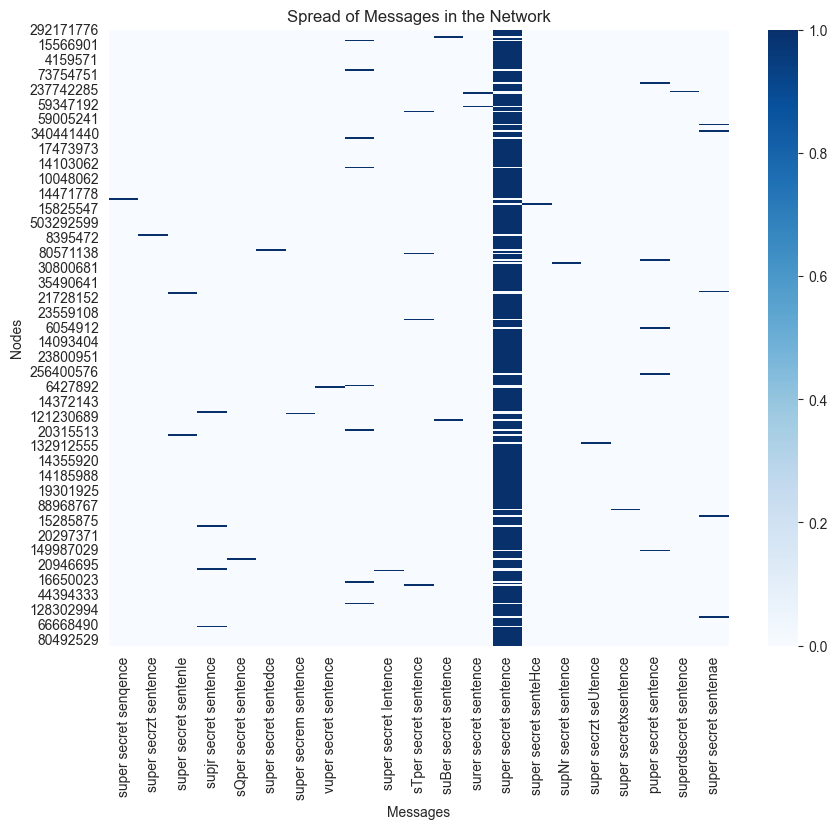

In [12]:
# Create a DataFrame where each row represents a node and each column represents a unique message
df = pd.DataFrame(0, index=G.nodes(), columns=list(unique_info))

# Fill the cells of the DataFrame with 0s and 1s
for node, info in information.items():
    df.loc[node, info] = 1

# Use seaborn's heatmap function to visualize the DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="Blues")
plt.title('Spread of Messages in the Network')
plt.xlabel('Messages')
plt.ylabel('Nodes')
plt.show()

### Cosine Similarity Heatmap

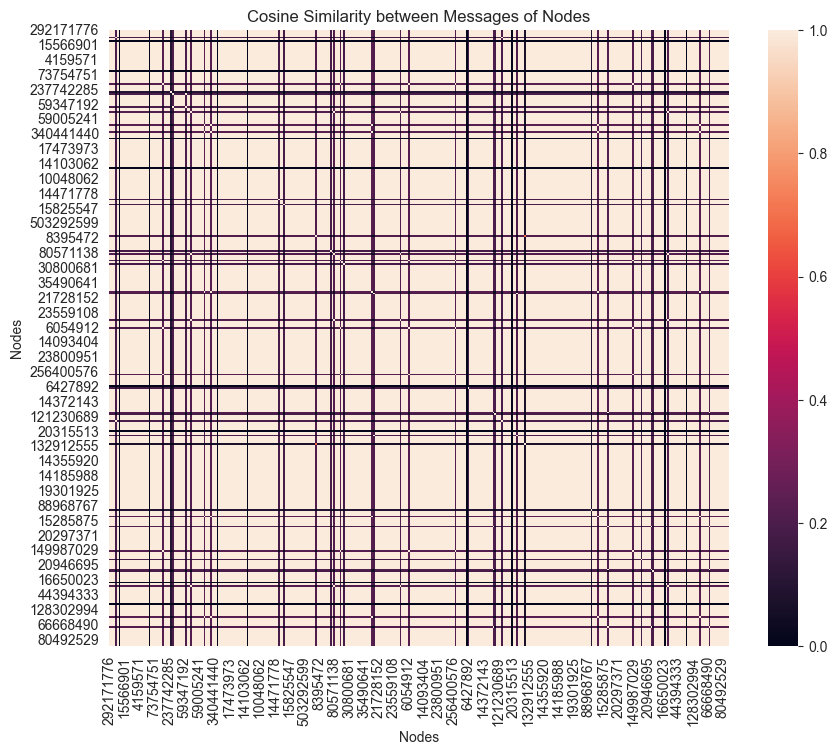

In [13]:
# Create a list of all messages received by the nodes
messages = [information[node] if information[node] is not None else '' for node in G.nodes()]

# Convert the messages into vectors using TF-IDF
vectorizer = TfidfVectorizer().fit_transform(messages)

# Compute the cosine similarity between all pairs of message vectors
cosine_sim = cosine_similarity(vectorizer)

# Create a DataFrame from the cosine similarity matrix
df = pd.DataFrame(cosine_sim, index=G.nodes(), columns=G.nodes())

# Visualize the DataFrame as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df)
plt.title('Cosine Similarity between Messages of Nodes')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

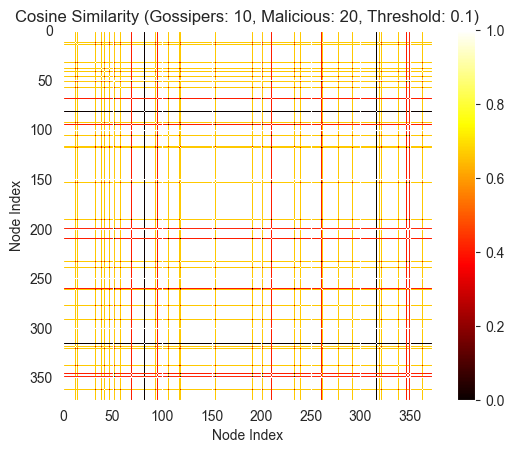

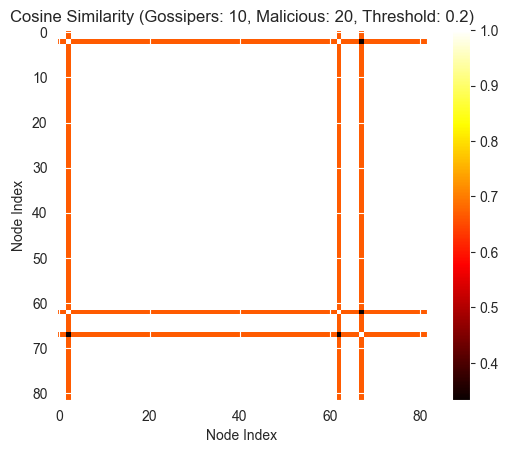

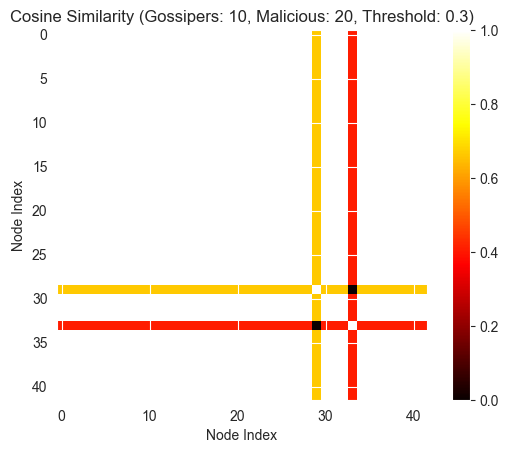

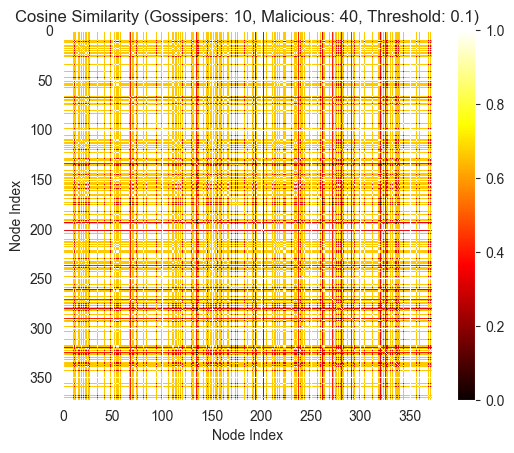

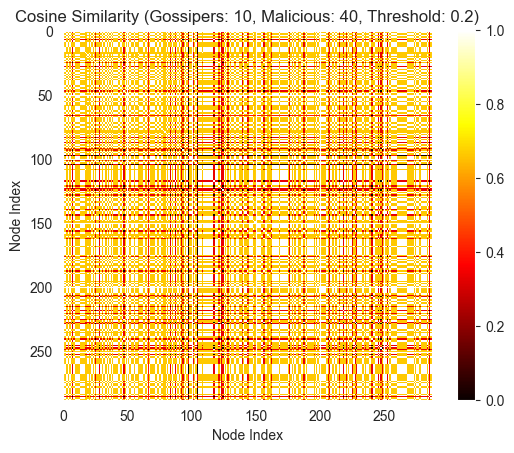

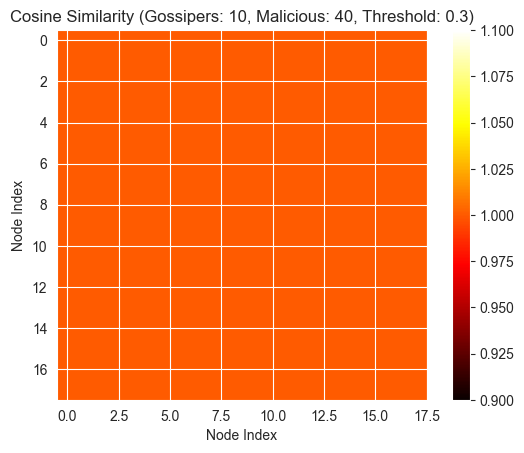

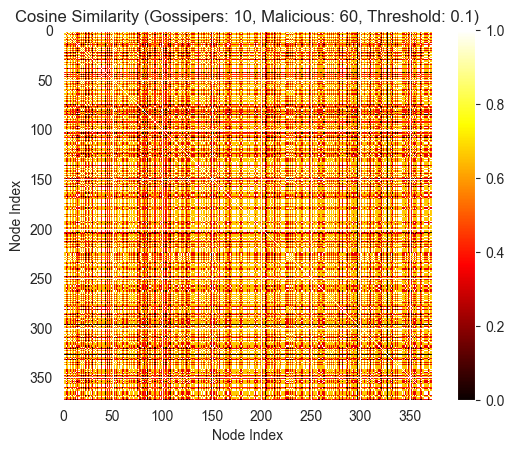

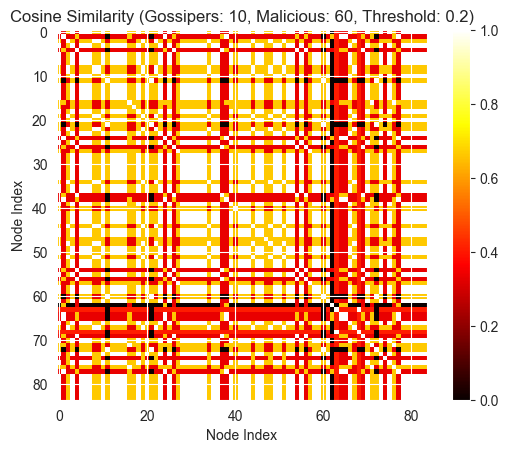

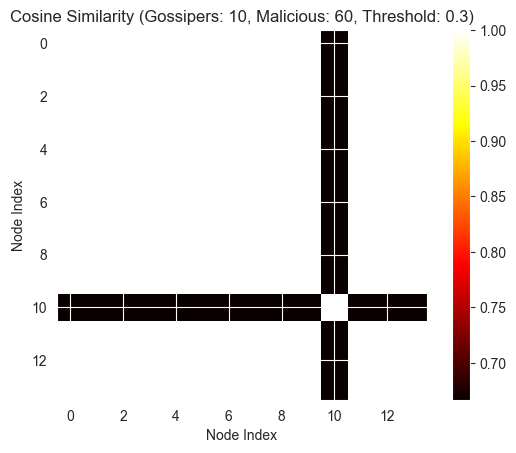

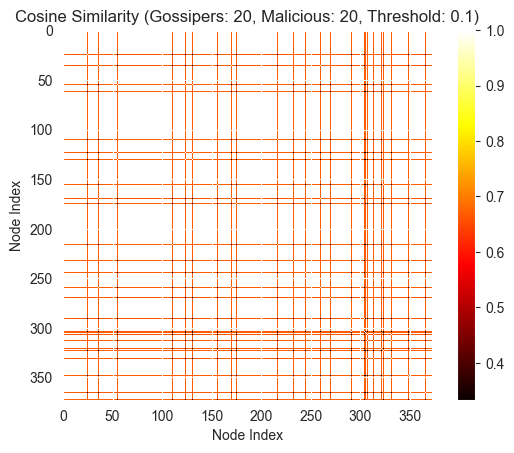

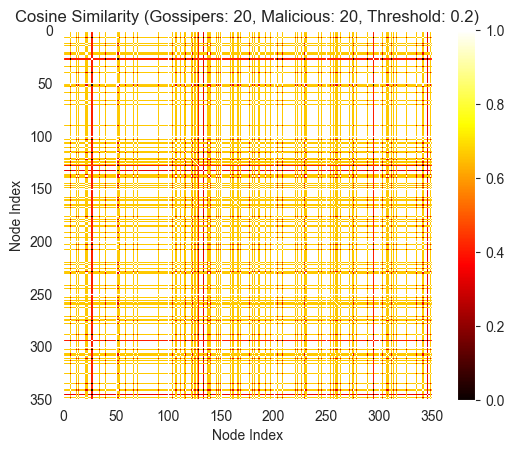

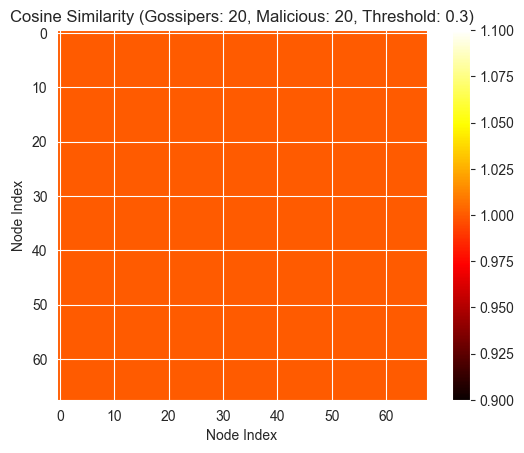

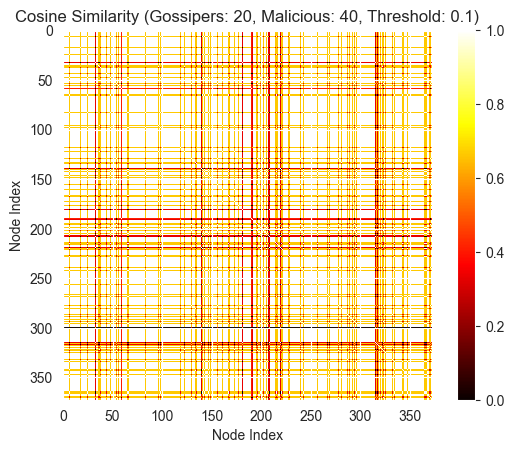

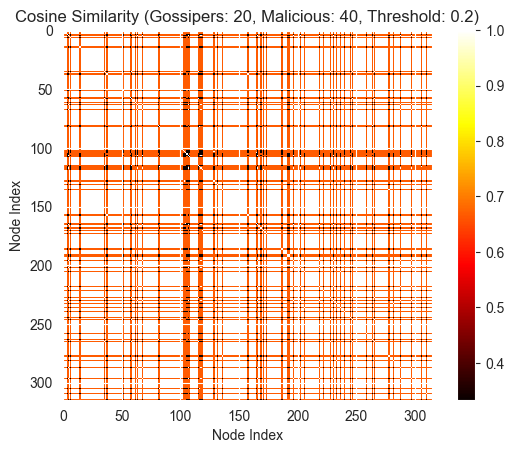

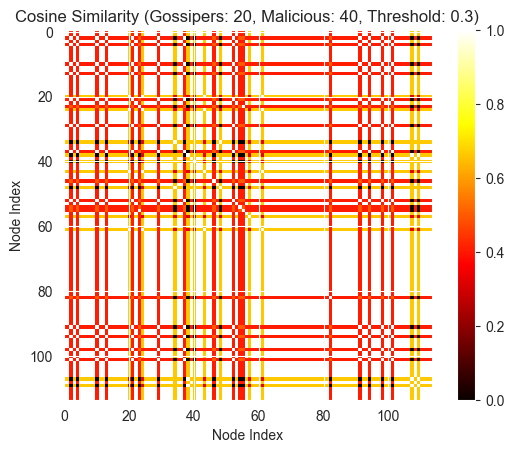

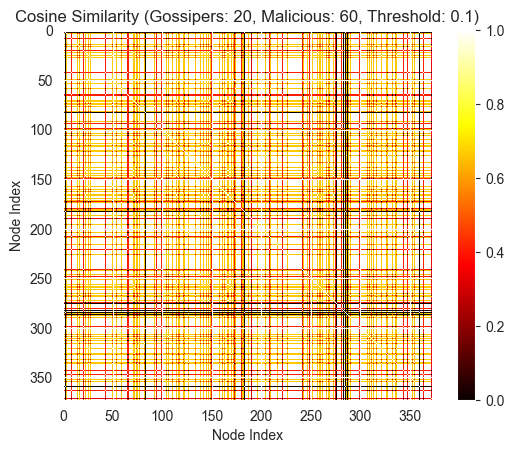

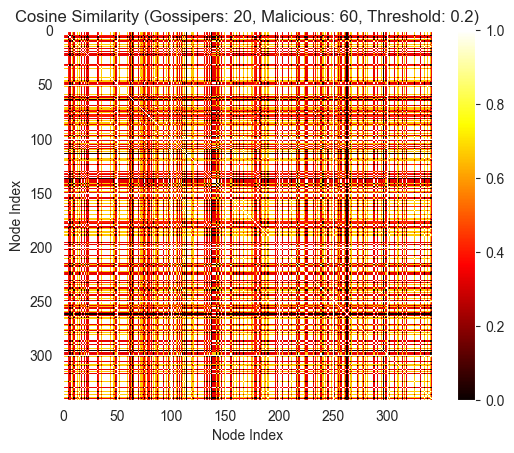

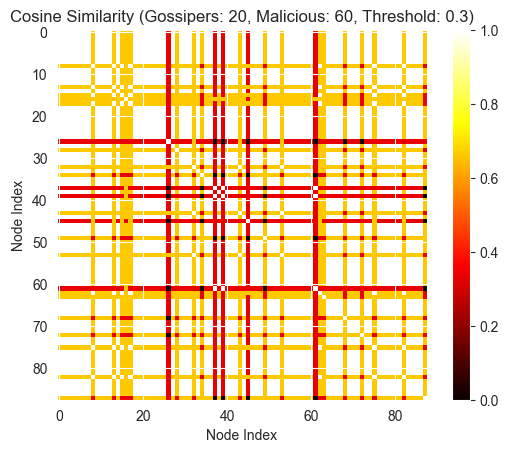

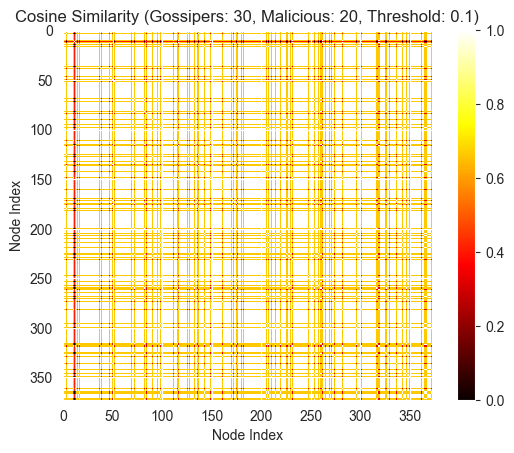

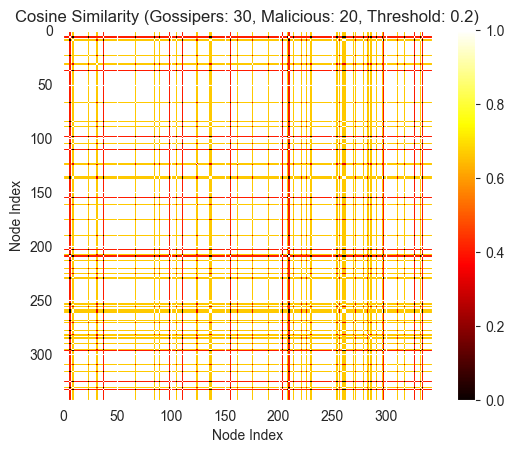

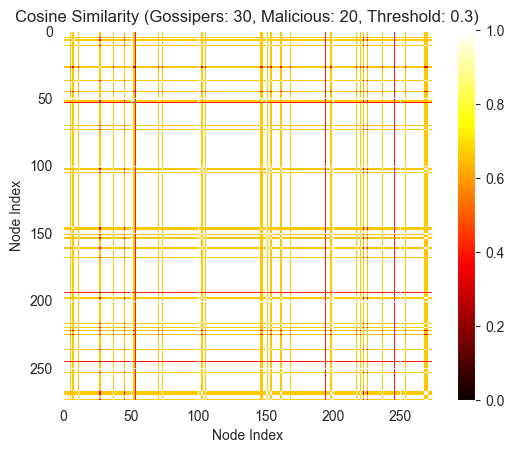

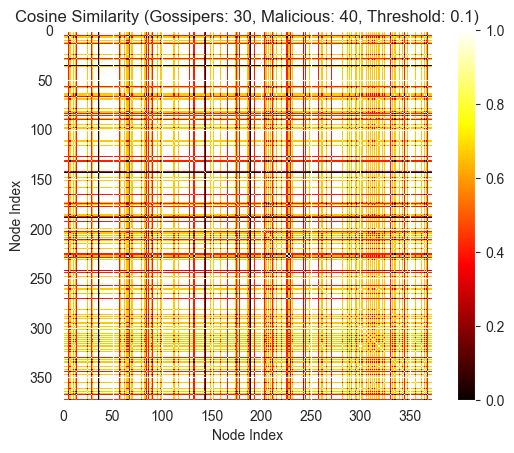

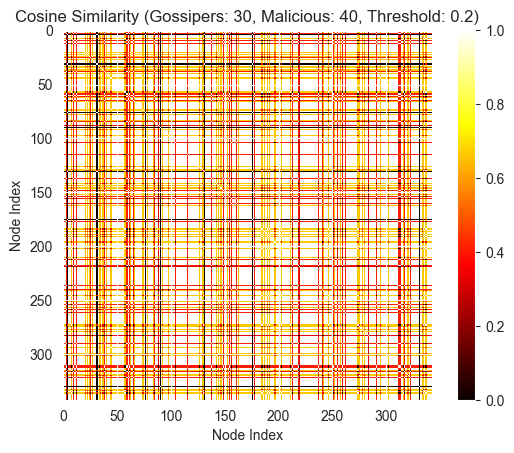

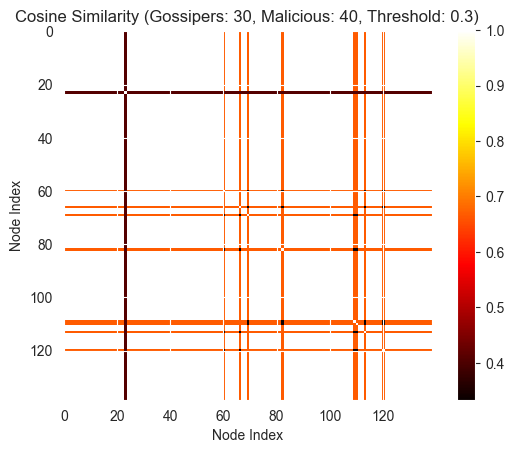

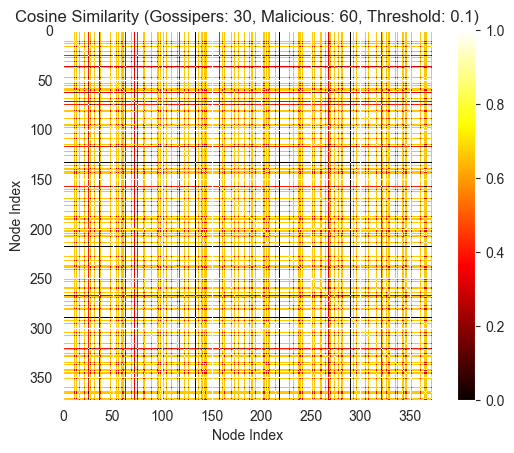

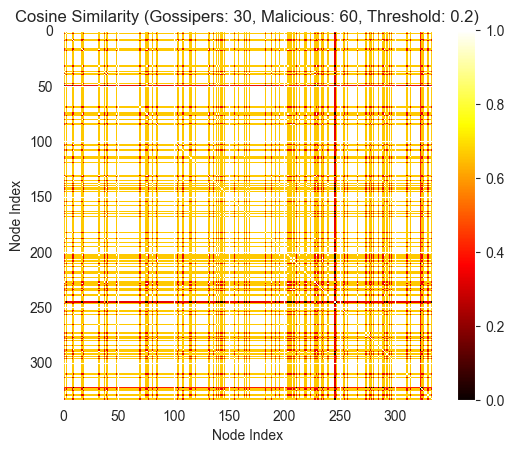

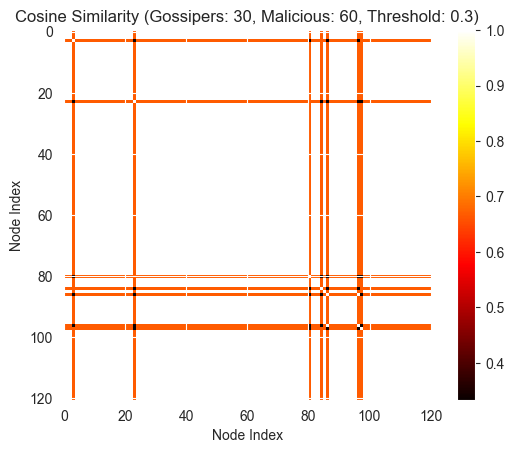

    gossiper_count  malicious_count  threshold  num_original  num_tampered  \
0               10               20        0.1           337            36   
1               10               20        0.2            79             3   
2               10               20        0.3            38             4   
3               10               40        0.1           241           132   
4               10               40        0.2            99           189   
5               10               40        0.3            18             0   
6               10               60        0.1           154           219   
7               10               60        0.2            46            38   
8               10               60        0.3            13             1   
9               20               20        0.1           345            28   
10              20               20        0.2           268            83   
11              20               20        0.3            68    

In [17]:
# Define New Functions for Cosine Similarity and Visualization
def compute_cosine_similarity(messages):
    filtered_messages = [msg for msg in messages if msg is not None]
    vectorizer = CountVectorizer().fit_transform(filtered_messages)
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)

def summarize_results(messages):
    original_message = "super secret sentence"
    num_original = sum(1 for msg in messages.values() if msg == original_message)
    num_tampered = sum(1 for msg in messages.values() if msg is not None and msg != original_message)
    num_uninformed = sum(1 for msg in messages.values() if msg is None)
    return num_original, num_tampered, num_uninformed

def visualize_heatmap(matrix, title):
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.colorbar()
    plt.show()

# Parameters to experiment with
gossiper_counts = [10, 20, 30]
malicious_counts = [20, 40, 60]
thresholds = [0.1, 0.2, 0.3]

# Running experiments with different parameters
results = []

for gossiper_count in gossiper_counts:
    for malicious_count in malicious_counts:
        for threshold in thresholds:
            # Reinitialize the network and set initial conditions
            G = giant_component_graph.copy()
            pos = nx.spring_layout(G)
            information = {node: None for node in G.nodes()}
            node_colors = {node: 'blue' for node in G.nodes()}

            initial_gossipers = random.sample(list(G.nodes()), gossiper_count)
            malicious = random.sample(list(G.nodes()), malicious_count)

            for gossiper in initial_gossipers:
                information[gossiper] = "super secret sentence"
                node_colors[gossiper] = 'green'

            # Main Loop
            max_iterations = 15
            iteration = 0

            while iteration < max_iterations:
                if not gossip_step(): break
                iteration += 1

            # Collecting messages
            message_list = list(information.values())
            num_original, num_tampered, num_uninformed = summarize_results(information)
            result_summary = {
                'gossiper_count': gossiper_count,
                'malicious_count': malicious_count,
                'threshold': threshold,
                'num_original': num_original,
                'num_tampered': num_tampered,
                'num_uninformed': num_uninformed
            }
            results.append(result_summary)

            # Compute and visualize cosine similarity
            cosine_sim_matrix = compute_cosine_similarity(message_list)
            title = f"Cosine Similarity (Gossipers: {gossiper_count}, Malicious: {malicious_count}, Threshold: {threshold})"
            visualize_heatmap(cosine_sim_matrix, title)

# Display results
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)
